In [69]:
import numpy as np
from matplotlib import pyplot as plt
import bgp_qnm_fits as bgp
import corner
import seaborn as sns 

# Constants
ID = '0001'
DATA_TYPE = 'news'
SPHERICAL_MODES = [(2, 2), (3,2), (4,2)]
THRESHOLD = 0.9
N_MAX = 6
T = 100
N_DRAWS = 10000
INCLUDE_CHIF = True
INCLUDE_MF = True
t0_vals = np.arange(0, 80.1, 5)

sim = bgp.SXS_CCE(ID, type=DATA_TYPE, lev="Lev5", radius="R2")
tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[ID]
Mf, chif = sim.Mf, sim.chif_mag

/data/vault/rvnd2/Code/qnmfits/qnmfits/Waveforms/Base.py:116: RuntimeWarning: divide by zero encountered in divide
  chidot = self.Jdot/(self.Moft**2).reshape(len(self.Moft),1)


In [ ]:
log_threshold = np.log(THRESHOLD)
initial_modes = [] #[(2,2,0,1), (3,2,0,1), (4,2,0,1)] #[(*s, 0, -1 if s[1] < 0 else 1) for s in SPHERICAL_MODES]
candidate_modes = [
   (*s, n, -1 if s[1] < 0 else 1) for s in SPHERICAL_MODES for n in range(0, N_MAX + 1)
]

# Fit modes
full_modes_list = []
for t0 in t0_vals:
    print(f'Fitting from t0={t0}')
    select_object = bgp.BGP_select(
        sim.times,
        sim.h,
        initial_modes,
        Mf,
        chif,
        tuned_param_dict_GP,
        bgp.kernel_GP,
        t0=t0,
        candidate_modes=candidate_modes,
        log_threshold=log_threshold,
        num_draws=N_DRAWS,
        T=T,
        spherical_modes=SPHERICAL_MODES,
        include_chif=INCLUDE_CHIF,
        include_Mf=INCLUDE_MF,
        data_type=DATA_TYPE
    )
    full_modes_list.append(select_object.full_modes)

Fitting from t0=0.0
Adding mode (2, 2, 0, 1) with significance 1.0.
Adding mode (2, 2, 1, 1) with significance 1.0.
Adding mode (2, 2, 2, 1) with significance 1.0.
Adding mode (2, 2, 3, 1) with significance 1.0.
Adding mode (3, 2, 0, 1) with significance 1.0.
Adding mode (3, 2, 1, 1) with significance 1.0.
Adding mode (3, 2, 2, 1) with significance 1.0.
Adding mode (4, 2, 0, 1) with significance 1.0.
Adding mode (4, 2, 1, 1) with significance 1.0.
Adding mode (3, 2, 3, 1) with significance 1.0.
Adding mode (2, 2, 4, 1) with significance 1.0.
Adding mode (4, 2, 2, 1) with significance 1.0.
Adding mode (4, 2, 3, 1) with significance 1.0.
Adding mode (3, 2, 4, 1) with significance 1.0.
Adding mode (2, 2, 5, 1) with significance 1.0.
Adding mode (4, 2, 4, 1) with significance 1.0.
Adding mode (4, 2, 5, 1) with significance 1.0.
Adding mode (3, 2, 5, 1) with significance 1.0.
Adding mode (2, 2, 6, 1) with significance 1.0.
Adding mode (4, 2, 6, 1) with significance 1.0.
Adding mode (3, 2, 6

In [64]:
# Helper function for masks
def masks(mode, full_modes_list):
    mask = np.array([mode in full_modes_list[i] for i in range(len(t0_vals))])
    changes = np.diff(mask.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0] + 1

    if mask[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if mask[-1]:
        end_indices = np.append(end_indices, len(mask))

    return [np.arange(start, end) for start, end in zip(start_indices, end_indices)]

/tmp/ipykernel_673285/3342979773.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=False, fontsize=6, bbox_to_anchor=(1., 1.), ncol=2)


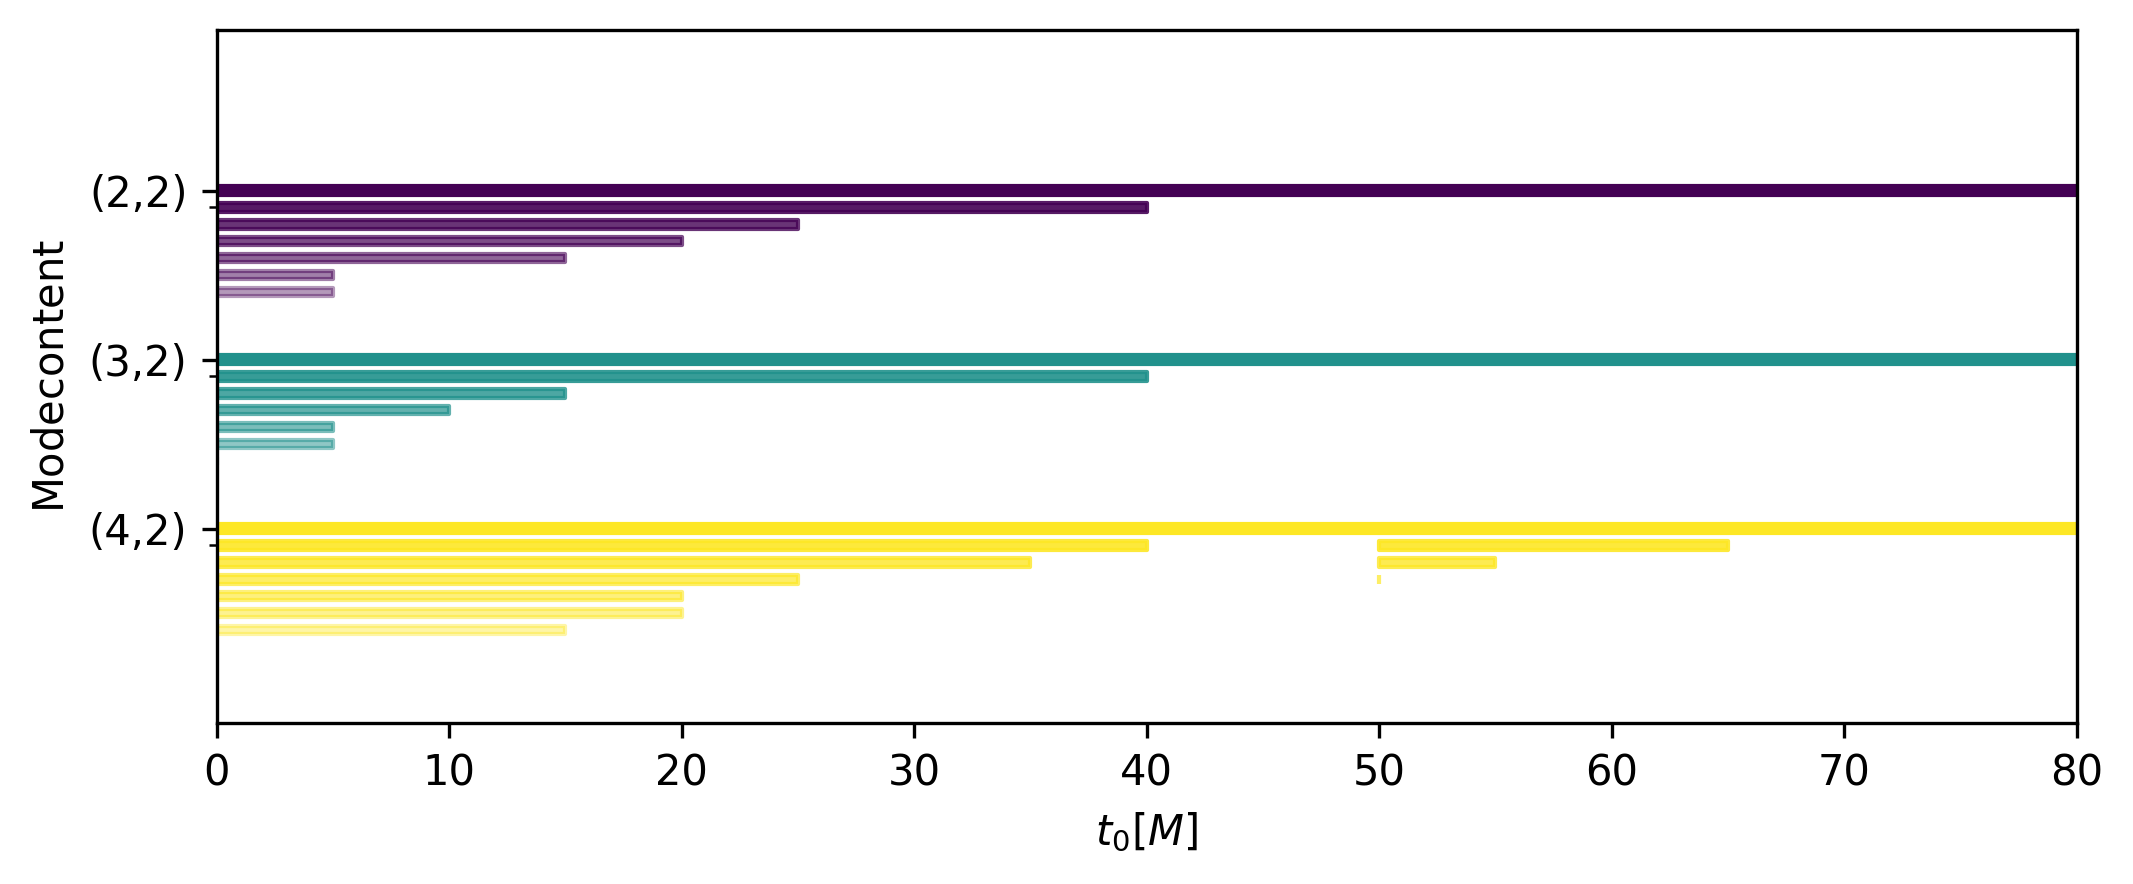

In [ ]:
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

y_tick_len = len(SPHERICAL_MODES)
colors = plt.cm.viridis(np.linspace(0, 1, y_tick_len))
lm_y_pos = [-i * 10 for i in range(y_tick_len)]
eps = 0.25

for mode in set(candidate_modes + initial_modes):
    if len(mode) == 4:
        l, m, n, _ = mode
        try:
            y = lm_y_pos[SPHERICAL_MODES.index((l, m))] - n
            color = colors[SPHERICAL_MODES.index((l, m))]
        except ValueError:
            continue
    elif len(mode) == 8:
        y, color = 8, 'k'
    elif len(mode) == 12:
        y, color = 4, 'k'

    for run in masks(mode, full_modes_list):
        ax.fill_between(
            t0_vals[run],
            y - eps,
            y - 1 + eps,
            color=color,
            alpha=1 - 0.1 * n if len(mode) == 4 else 1,
        )

# Axis labels and ticks
ax.set_xlabel(r"$t_0 [M]$")
ax.set_ylabel(r"$\rm Mode content$")
ax.set_xlim(0, t0_vals[-1])
ax.set_ylim(-(y_tick_len - 1) * 12 - N_MAX - 2, 9)

ticks = [lm_y_pos[i] - 0.5 for i in range(y_tick_len)]
ax.set_yticks(ticks)
ax.set_yticklabels([f"({l},{m})" for l, m in SPHERICAL_MODES])
ax.yaxis.set_minor_locator(FixedLocator([tick - 1 for tick in ticks]))

ax.legend(loc='upper right', frameon=False, fontsize=6, bbox_to_anchor=(1., 1.), ncol=2)

In [66]:
amplitudes_array = np.zeros((len(t0_vals), N_DRAWS))
target_mode = (4, 2, 2, 1)

for i, t0 in enumerate(t0_vals):

    full_fit_1 = bgp.BGP_fit(
        sim.times,
        sim.h,
        full_modes_list[i].copy(),
        Mf,
        chif,
        tuned_param_dict_GP,
        bgp.kernel_GP,
        t0=t0,
        use_nonlinear_params=False,
        num_samples=N_DRAWS,
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        include_chif=INCLUDE_CHIF,
        include_Mf=INCLUDE_MF,
        strain_parameters=False,
        data_type=DATA_TYPE
    )
    model_1 = full_fit_1.fit["sample_amplitudes"]
    if target_mode in full_modes_list[i]:
        mode_index = full_modes_list[i].index(target_mode)
        amplitudes_array[i, :] = model_1[:, mode_index]
    


KeyboardInterrupt: 

In [67]:
amplitudes_array_test = np.zeros((len(t0_vals), N_DRAWS))
target_mode = (4, 2, 2, 1)

for i, t0 in enumerate(t0_vals):

    modes = full_modes_list[i].copy() 
    if target_mode not in modes:
        modes += [target_mode]

    mode_index = modes.index(target_mode)

    full_fit_1 = bgp.BGP_fit(
        sim.times,
        sim.h,
        modes,
        Mf,
        chif,
        tuned_param_dict_GP,
        bgp.kernel_GP,
        t0=t0,
        use_nonlinear_params=False,
        num_samples=N_DRAWS,
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        include_chif=INCLUDE_CHIF,
        include_Mf=INCLUDE_MF,
        strain_parameters=False,
        data_type=DATA_TYPE
    )
    model_1 = full_fit_1.fit["sample_amplitudes"]
    amplitudes_array_test[i, :] = model_1[:, mode_index]

In [ ]:
amplitudes_array_full = np.zeros((len(t0_vals), N_DRAWS))
model = [(2,2,0,1), (3,2,0,1), (4,2,0,1), (4,2,1,1), (4,2,2,1), (4,2,3,1), (4,2,4,1)]

mode_index = model.index(target_mode)

for i, t0 in enumerate(t0_vals):

    full_fit_1 = bgp.BGP_fit(
        sim.times,
        sim.h,
        model,
        Mf,
        chif,
        tuned_param_dict_GP,
        bgp.kernel_GP,
        t0=t0,
        use_nonlinear_params=False,
        num_samples=N_DRAWS,
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        include_chif=INCLUDE_CHIF,
        include_Mf=INCLUDE_MF,
        strain_parameters=False,
        data_type=DATA_TYPE
    )
    model_1 = full_fit_1.fit["sample_amplitudes"]
    amplitudes_array_full[i, :] = model_1[:, mode_index]

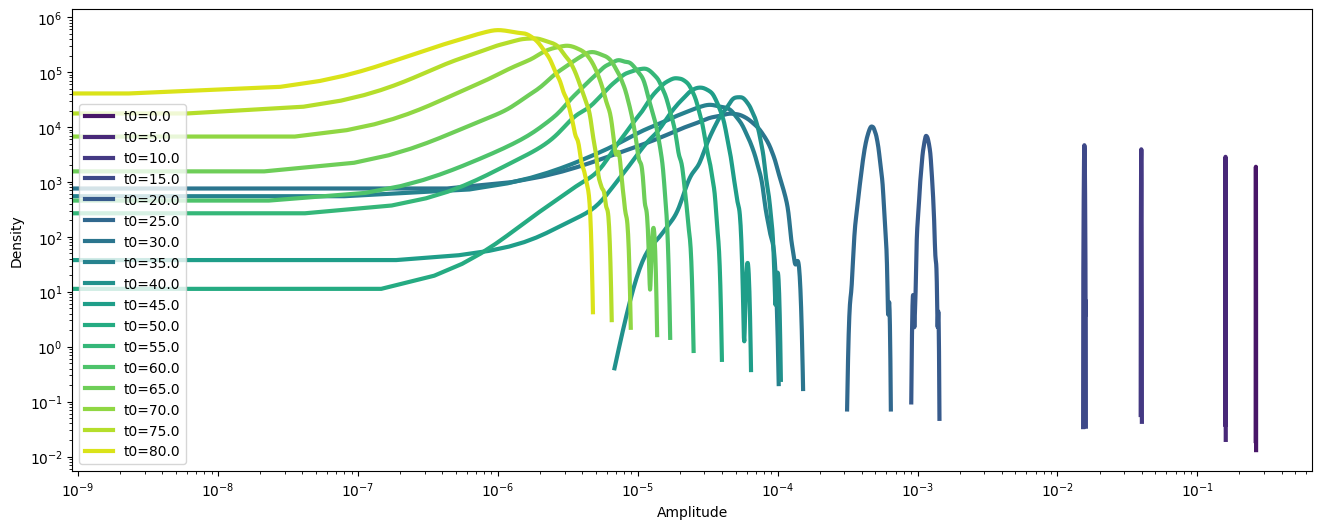

In [ ]:
plt.figure(figsize=(16, 6))
palette_subset = sns.color_palette("viridis", len(t0_vals))
for i, (t0, amps) in enumerate(zip(t0_vals, amplitudes_array_full)):
    samples = amps.flatten()
    if target_mode not in full_modes_list[i]:
        ls = '--'
    else:
        ls = '-'
    sns.kdeplot(samples, label=f't0={t0}', color=palette_subset[i], linewidth=3, linestyle=ls)
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.yscale('log')
#plt.xlim(-1e-5, 5e-5)
plt.xscale('log')
plt.legend()
plt.show()

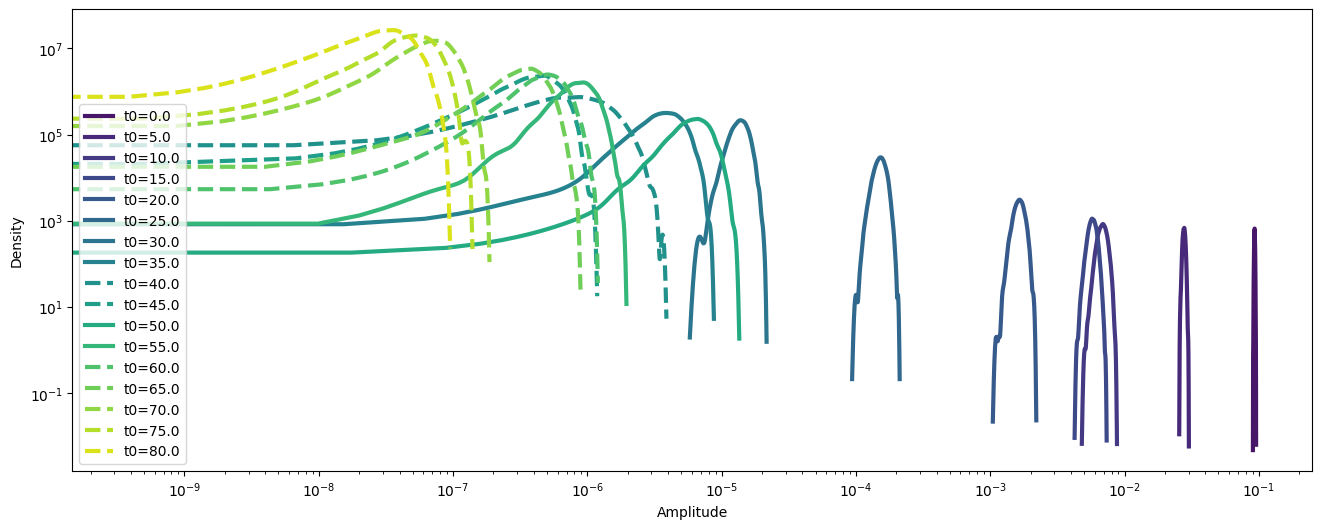

In [68]:
plt.figure(figsize=(16, 6))
palette_subset = sns.color_palette("viridis", len(t0_vals))
for i, (t0, amps) in enumerate(zip(t0_vals, amplitudes_array_test)):
    samples = amps.flatten()
    if target_mode not in full_modes_list[i]:
        ls = '--'
    else:
        ls = '-'
    sns.kdeplot(samples, label=f't0={t0}', color=palette_subset[i], linewidth=3, linestyle=ls)
plt.xlabel('Amplitude')
plt.ylabel('Density')
plt.yscale('log')
#plt.xlim(-1e-5, 5e-5)
plt.xscale('log')
plt.legend()
plt.show()